In [1]:
import numpy as np
import pandas as pd
#import os
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from sklearn import preprocessing

In [2]:
raw_path = 'https://raw.githubusercontent.com/Genia163/relative_spectrum/main/%D0%9E%D0%BF%D1%8B%D1%82%D1%8B%20%D0%BE%D1%82%2018.02.23_signal_data.csv'

In [3]:
#exp_path = 'Опыты от 18.02.23'
#Path = os.getcwd()
#Path = f'{Path}/{exp_path}'
#all_signals = pd.read_csv(f'{exp_path}_signal_data.csv',)
SAMPLE_RATE = 2*10**6

all_signals = pd.read_csv(raw_path)
all_signals = all_signals.fillna(0)
channels = all_signals.channel.unique()
num_exps = all_signals.num_exp.unique()
durations = []
for i in range(len(all_signals.num_exp)):
    durations.append(all_signals.num_exp[i].split("_")[1])
series = []
for i in range(len(all_signals.num_exp)):
    series.append(all_signals.num_exp[i].split("_")[0])
#all_signals['num_exp'] = series
#all_signals = all_signals.rename(columns={"num_exp": "series"})
all_signals.insert(1, 'series', series)
all_signals.insert(2, 'duration', durations)
all_signals = all_signals.drop('num_exp', axis = 1)
series = all_signals.series.unique()
durations = all_signals.duration.unique()

In [4]:
all_signals

,channel,series,duration,count_dot,0,1,2,3,4,5,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,ch1,1,"0,1",2000.0,-107.0,-55.0,38.0,-26.0,-124.0,-54.0,...,-53.0,-31.0,-31.0,-24.0,-19.0,-33.0,-50.0,-41.0,-16.0,1.0
1,ch1,1,"0,1",2000.0,-106.0,-28.0,64.0,-23.0,-119.0,-20.0,...,-51.0,-34.0,-31.0,-28.0,-27.0,-33.0,-41.0,-38.0,-21.0,4.0
2,ch1,1,"0,1",2000.0,103.0,74.0,-13.0,27.0,108.0,67.0,...,-28.0,-20.0,-13.0,-27.0,-41.0,-28.0,-8.0,-8.0,-9.0,9.0
3,ch1,1,"0,1",2000.0,-92.0,-7.0,74.0,-20.0,-104.0,3.0,...,-49.0,-35.0,-29.0,-28.0,-29.0,-31.0,-31.0,-30.0,-18.0,10.0
4,ch1,1,"0,1",2000.0,-93.0,-66.0,18.0,-22.0,-110.0,-67.0,...,-54.0,-28.0,-29.0,-23.0,-15.0,-29.0,-49.0,-40.0,-14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,ch2,3,6,2000.0,50.0,85.0,78.0,136.0,352.0,523.0,...,151.0,638.0,594.0,191.0,112.0,418.0,448.0,-69.0,-511.0,-345.0
296,ch2,3,6,2000.0,73.0,84.0,88.0,223.0,464.0,471.0,...,423.0,701.0,411.0,89.0,240.0,498.0,241.0,-341.0,-505.0,-156.0
297,ch2,3,6,2000.0,77.0,82.0,95.0,248.0,485.0,444.0,...,483.0,694.0,362.0,82.0,277.0,497.0,172.0,-399.0,-488.0,-121.0
298,ch2,3,6,2000.0,83.0,78.0,114.0,307.0,517.0,349.0,...,592.0,647.0,257.0,95.0,366.0,468.0,8.0,-496.0,-414.0,-46.0


0,3 0,1 10


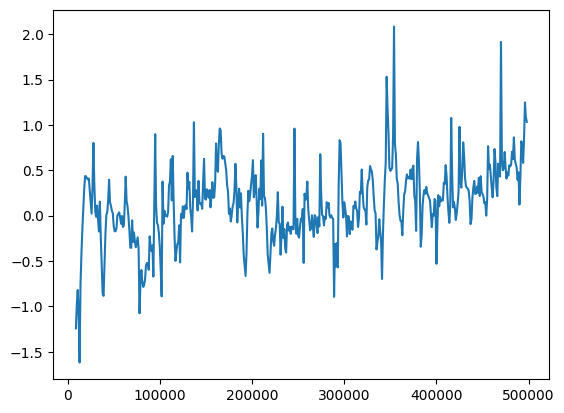

In [90]:
print(durations[1],durations[0], len(durations))
rel_spect_wfreq_log(i1 = 0, i2 = 0, ch_num1 = 0, ch_num2 = 0,  n_series1 = 0, duration1 = 0, n_series2 = 0, duration2 = 9, normalize = True, f_low = 10000, f_high = 500000)

In [88]:
def sel_exp(ch_num, n_series, duration):
    """
    Возвращает кусок DF только по выбранным номерам канала и эксперимента
    в списках каналов и экспериментов
    """
    ch = channels[ch_num]
    dur = durations[duration]
    ser = series[n_series]
    return all_signals[(all_signals['channel'] == ch) & (all_signals['duration'] == dur) & (all_signals['series'] == ser)]

def exps_count(ch_num, n_series, duration):
    """
    Возвращает число элементов в куске DF с нужным каналом и экспериментом
    """
    return sel_exp(ch_num, n_series, duration).shape[0]

def ith_signal(i, ch_num, n_series, duration, normalize):
    """
    Возвращает i-й сигнал из куска DF с нужным каналом и экспериментом
    normalize = True для задействования нормализации
    """
    from sklearn.preprocessing import normalize as do_norm
    df = sel_exp(ch_num, n_series, duration)
    if i >= exps_count(ch_num, n_series, duration): return 'You sluty bustard, why did you do that?'
    elif normalize: return do_norm(df[i:i+1].loc[:, "0":"1999":1], axis = 1)
    else: return df[i:i+1].loc[:, "0":"1999":1]

def ith_spect(i, is_abs, ch_num, n_series, duration, normalize):
    """
    Возвращает спектр i-го сигнала из куска DF с нужным каналом и экспериментом
    is_abs = True для взятия по модулю, без него - комплексные коэффциенты
    """
    from numpy import abs
    from scipy.fft import rfft
    if is_abs: return abs(rfft(ith_signal(i, ch_num, n_series, duration, normalize)))[0]
    else: return rfft(ith_signal(i, ch_num, n_series, duration, normalize))[0]

def ith_spect_wfreq(i, ch_num, n_series, duration, normalize, f_low, f_high):
    SAMPLE_RATE = 2*10**6
    N = ith_signal(i, ch_num, n_series, duration, normalize).shape[1]
    yf = ith_spect(i, True, ch_num, n_series, duration, normalize)
    xf0 = rfftfreq(int(N), 1/float(SAMPLE_RATE))
    i = 0
    i_low = 0
    i_high = 0
    for freq in xf0:
        if freq < f_low: i_low = i
        elif freq < f_high: i_high = i
        i+=1
    return [xf[i_low:i_high],yf[i_low:i_high]]

def spect_ccc(i1, i2, ch_num1, ch_num2, n_series1, duration1, n_series2, duration2, normalize):
    """
    Возвращает коэффициент корреляции между 
    i1-м сигналом канала ch_num1 эксперимента exp_num1 и
    i2-м сигналом канала ch_num2 эксперимента exp_num2
    """
    from scipy.stats import pearsonr as corr_coeff
    from sklearn.metrics import r2_score
    #раскоммитить первую строку для CCC, вторую для R2
    #return corr_coeff(ith_spect(i1, True, ch_num1, n_series1, duration1, normalize), ith_spect(i2, True, ch_num2, n_series2, duration2, normalize))[0]
    return r2_score(ith_spect(i1, True, ch_num1, n_series1, duration1, normalize), ith_spect(i2, True, ch_num2, n_series2, duration2, normalize))
    
def spect_cc_func(i1, i2, ch_num1, ch_num2,  n_series1, duration1, n_series2, duration2, normalize):
    """
    Возвращает взаимнокорреляционную функцию для 
    i1-го сигнала канала ch_num1 эксперимента exp_num1 и
    i2-го сигнала канала ch_num2 эксперимента exp_num2
    """
    from scipy.signal import correlate
    return correlate(ith_spect(i1, True, ch_num1, n_series1, duration1, normalize), ith_spect(i2, True, ch_num2, n_series1, duration1, normalize))

def rel_spect_log(i1, i2, ch_num1, ch_num2,  n_series1, duration1, n_series2, duration2, normalize):
    from numpy import log10
    return log10(ith_spect(i1, True, ch_num1, n_series1, duration1, normalize)/ith_spect(i2, True, ch_num2, n_series2, duration2, normalize))

def rel_spect_wfreq_log(i1, i2, ch_num1, ch_num2,  n_series1, duration1, n_series2, duration2, normalize, f_low, f_high):
    from numpy import log10
    from matplotlib.pyplot import plot
    tmp1 = ith_spect_wfreq(i1, ch_num1, n_series1, duration1, normalize, f_low, f_high)
    tmp2 = ith_spect_wfreq(i2, ch_num2, n_series2, duration2, normalize, f_low, f_high)
    plot(tmp1[0], log10(tmp1[1]/tmp2[1]))

In [7]:
# Формируем имена столбцов для таблицы коэффициентов корреляции внутри одного эксперимента
imax = exps_count(ch_num = 0, n_series = 0, duration = 0)
cc_names = ['channel1', 'channel2', 'series1', 'series2', 'duration1', 'duration2']
for i in range(imax-1):
    for j in range(imax-1-i):
        cc_names.append('cc_'+str(imax-1-i)+','+str(j))
cc_names.append('min_cc')
cc_names.append('mean_cc')
    
def ccc_onemeasure_df_row(ch_num1, ch_num2, n_series1, duration1, n_series2, duration2, normalize):
    from numpy import array
    from scipy.special import binom
    arr = [channels[ch_num1], channels[ch_num2], 
           series[n_series1], series[n_series2], 
           durations[duration1], durations[duration2]]
    tmp = 0
    mean_tmp = 0
    min_tmp = 1
    for i in range(imax-1):
        for j in range(imax-1-i):
            tmp = spect_ccc(imax-1-i, j, ch_num1, ch_num2, n_series1, duration1, n_series2, duration2, normalize)
            mean_tmp += tmp
            arr.append(tmp)
            if tmp < min_tmp: min_tmp = tmp
    arr.append(min_tmp)
    arr.append(mean_tmp/binom(exps_count(ch_num1, n_series1, duration1), 2))
    return array(arr)

def ccc_onemeasure_df(normalize):
    from pandas import DataFrame
    arr = []
    for i in range(len(durations)):
        for j in range(len(series)):
            for k in range(len(channels)):
                arr.append(ccc_onemeasure_df_row(k, k, j, i, j, i, normalize))
    return DataFrame(data = arr,
                     columns = cc_names)

In [ ]:
ccc_onemeasure_df(normalize = True).to_csv('r2score_onemeasure_df_normalize.csv')
ccc_onemeasure_df(normalize = True)

In [6]:
# Формируем имена столбцов для таблицы коэффициентов корреляции между двумя сериями экспериментов
imax = exps_count(ch_num = 0, n_series = 0, duration = 0)
cc_names = ['channel1', 'channel2', 'duration1', 'duration2']
for i in range(imax-1):
    for j in range(imax-1):
        for k in range(len(series)):
            for l in range(len(series)-k):
                if k!=l: cc_names.append('cc_s'+str(k)+','+str(l)+"_i"+str(imax-1-i)+','+str(j))
cc_names.append('min_cc')
cc_names.append('mean_cc')

def ccc_btwnseries_df_row(ch_num1, ch_num2, duration1, duration2, normalize):
    from numpy import array
    #from scipy.special import binom
    arr = [channels[ch_num1], channels[ch_num2], 
           durations[duration1], durations[duration2]]
    tmp = 0
    mean_tmp = 0
    min_tmp = 1
    cntr = 0
    for i in range(imax-1):
        for j in range(imax-1):
            for k in range(len(series)):
                for l in range(len(series)-k):
                    if k!=l:
                        tmp = spect_ccc(imax-1-i, j, 
                                        ch_num1, ch_num2, 
                                        k, duration1,
                                        l, duration2, 
                                        normalize)
                        mean_tmp += tmp
                        arr.append(tmp)
                        if tmp < min_tmp: min_tmp = tmp
                        cntr+=1
    arr.append(min_tmp)
    arr.append(mean_tmp/cntr)
    return array(arr)

def ccc_btwnseries_df(normalize):
    from pandas import DataFrame
    arr = []
    for i in range(len(durations)):
        for j in range(len(channels)):
                arr.append(ccc_btwnseries_df_row(j, j, i, i, normalize))
    return DataFrame(data = arr,
                     columns = cc_names)

In [8]:
ccc_btwnseries_df(normalize = True).to_csv('r2score_btwnseries_df_normalize.csv')
ccc_btwnseries_df(normalize = True)

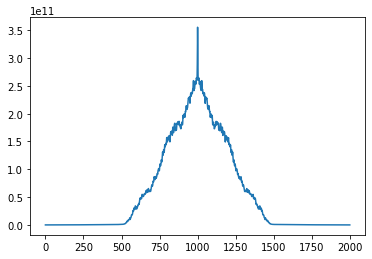

In [483]:
plt.plot(spect_cc_func(i1 = 0, i2 = 4, ch_num1 = 1, ch_num2 = 1, n_series1 = 0, duration1 = 0, n_series2 = 0, duration2 = 0, normalize = False))